# Practical Machine Learning for Physicists
## Autoencoder Challenge


For both of these tasks we want you to implement autoencoder networks that:
- Train on randomly generated circles (using the circle_generator function below)
- Use 27x27 pixel images
- Use no more than 30,000 randomly generated samples (e.g. batchsize 30 and 1000 steps, or batchsize 1000 and 30 steps, or anywhere inbetween) in training the final networks for each task
- Use the mean_squared_error loss function
- Fulfil the network size requirement listed in the task (can be verifired using the print_layers function, after the network is partially trained)

### Task 1:
Implement any network design, but the bottleneck must contain no more than 9 neurons.

### Task 2:
Implement any network design, but the bottleneck must contain no more than 3 neurons.



#### Practicalities
You should use this notebook for your work and upload it to both Moodle and CoCalc. You are expected to use TensorFlow and Keras to complete these tasks. The notebook should be self-contained and able to be executed if necessary. Marks will be awarded for (roughly equally weighted):
- Overall notebook clarity (both in terms of good coding practice and coherent discussion)
- Task 1 performance (0.02 is a good target cost to do better than)
- Task 2 performance ( a good target here is left for the student to determine)



# Start of Exercise

Before starting the tasks, the necessary libraries need to be imported. This cell block is copied from `Week4_ConvolutionalNeuralNetwork.ipynb` from Moodle. 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import math

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

import matplotlib.style #Some style nonsense
import matplotlib as mpl #Some more style nonsense

#Set default figure size
#mpl.rcParams['figure.figsize'] = [12.0, 8.0] #Inches... of course it is inches
mpl.rcParams["legend.frameon"] = False
mpl.rcParams['figure.dpi']=200 # dots per inch

#Useful for debugging problems
print(tf.__version__)

2.6.0


This block of code is copied from `Week4_Autoencoder.ipynb`. Basically, there are 6 functions that are defined in this code cell. 

The most important is `generate_and_train`, which is the function that is used to train our model. `model` is the model built using keras, `image_generator` is the image generator function that will be defined later, `img_size` is the image size in pixels, we will use 27 for img_size as our image is 27x27 pixels in size. `batchsize` is the number of images per step. `steps` is the amount of training batches. 

`get_test_image` generates a test image from the image generator function, this will be used as a reference for what the generated images will look like. In our case, it will be a circle of random size and random position. 

`plot_test_image` outputs an image using the model, it will be used after our model is trained to see how visually accurate our model is. 

`print_layers` will be called after the model is trained. It will output the layers of the network so that we can see how many neurons are in each layer. This will be used to check that we have the correct amount of neurons in the "bottleneck" that is required by each task. 

I didn't use `get_layer_activation_extractor` or `get_layer_activations` but they can be useful to visualise the network layers. 




In [ ]:
#A big messy function to do the training
# model -- our keras neural model autoencoder
# image_generator -- a function to generate random images for the training (see below for examples)
# img_size -- the size of our image in pixels
# batchsize -- the number of images to include in each training batch
# steps -- the number of steps taken in the training
#
# returns an array of the costs
def generate_and_train(model,image_generator,img_size,batchsize,steps):
   
    #Generate an array of the numbers 1 to img_size and create a meshgrid from them    
    pixels=np.linspace(-1,1,img_size)
    x,y=np.meshgrid(pixels,pixels)
    
    #Now create a test image using 1 call to image_generator
    #y_test=np.zeros([1,pixels,pixels,1])
    #y_test[:,:,:,0]=image_generator(1,x,y)
    
    #Now create the empty arrays for the images and cost
    y_in=np.zeros([batchsize,img_size,img_size,1])
    y_target=np.zeros([batchsize,img_size,img_size,1])
    cost=np.zeros(steps)
    
    #Loop through the steps, get a random batch of samples, train the model, repeat
    for k in range(steps):
        # produce samples:
        y_in[:,:,:,0]=image_generator(batchsize,x,y)
        y_target=np.copy(y_in) # autoencoder wants to reproduce its input!
        
        # do one training step on this batch of samples:
        cost[k]=model.train_on_batch(y_in,y_target)
    
    return cost,y_target

def get_test_image(image_generator,img_size):
    #Generate an array of the numbers 1 to img_size and create a meshgrid from them    
    pixels=np.linspace(-1,1,img_size)
    x,y=np.meshgrid(pixels,pixels)
    
    #Now create a test image using 1 call to image_generator
    y_test=np.zeros([1,img_size,img_size,1])
    y_test[:,:,:,0]=image_generator(1,x,y)
    return y_test

# A function to generate and plot a single test image and the output of our model
# only to be called after training the model
def plot_test_image(model,image_generator,img_size):
    #Get random test image
    y_test=get_test_image(image_generator,img_size)
    
    #Create the output image
    y_test_out=model.predict_on_batch(y_test)
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(y_test[0,:,:,0],origin='lower')
    ax[0].set_title("Input")
    ax[1].imshow(y_test_out[0,:,:,0],origin='lower')
    ax[1].set_title("Output")
    
def print_layers(network, y_in):
    """
    Call this on some test images y_in, to get a print-out of
    the layer sizes. Shapes shown are (batchsize,pixels,pixels,channels).
    After a call to the visualization routine, y_target will contain
    the last set of training images, so you could feed those in here.
    """
    layer_features=get_layer_activations(network,y_in)
    #print(layer_features)
    for idx,feature in enumerate(layer_features):
        s=np.shape(feature)
        print("Layer "+str(idx)+": "+str(s[1]*s[2]*s[3])+" neurons / ", s)

def get_layer_activation_extractor(network):
    #print(network.inputs)
    #for layer in network.layers:
    #    print(layer.output)
    return(keras.Model(inputs=network.inputs,
                            outputs=[layer.output for layer in network.layers]))

def get_layer_activations(network, y_in):
    """
    Call this on some test images y_in, to get the intermediate 
    layer neuron values. These are returned in a list, with one
    entry for each layer (the entries are arrays).
    """
    extractor=get_layer_activation_extractor(network)
    #print(extractor)
    layer_features = extractor(y_in)
    return layer_features
    

## Circle generator
This function generates a random sized circle at a random position. It will be used to generate however many images required to train our model.

In [ ]:
# A simple image generator that returns an array of batchsize images
# each image has a size of x * y pixels
# in this image each image has a randomly placed circle (and the circle is of random size)
def circle_generator(batchsize,x,y):
    R=np.random.uniform(size=batchsize)
    x0=np.random.uniform(size=batchsize,low=-1,high=1)
    y0=np.random.uniform(size=batchsize,low=-1,high=1)
    return( 1.0*((x[None,:,:]-x0[:,None,None])**2 + (y[None,:,:]-y0[:,None,None])**2 < R[:,None,None]**2) )


## Task 1

`model2` is the autoencoder with a bottleneck of 9 neurons. The code is copied from `Week4_autoencoder.ipynb` and modified. I changed all the activations from "Sigmoid" to "relu", which seems to provide lower loss values based on testing. This model uses Conv2D, AveragePooling2D, and UpSampling2D layers. `Conv2D` is a convolution layer. `AveragePooling2D` downsamples the input along its spatial dimensions (height and width) by taking the average value over an input window (of size defined by pool_size) for each channel of the input (from https://www.tensorflow.org/api_docs/python/tf/keras/layers/AveragePooling2D). `UpSampling2D` upsamples 2D inputs by repeating the rows and columns of the data by size[0] and size[1] respectively (from https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D)

In [ ]:
model2=keras.models.Sequential()
# 3x3 kernel size, 10 channels in first hidden layer:
model2.add(keras.layers.Conv2D(4,5,input_shape=(None,None,1),activation="relu",padding='same'))
model2.add(keras.layers.AveragePooling2D(pool_size=(3,3),padding='same')) # down
model2.add(keras.layers.Conv2D(4,5,activation="relu",padding='same'))
model2.add(keras.layers.AveragePooling2D(pool_size=(3,3),padding='same')) # down
model2.add(keras.layers.Conv2D(1,3,activation="relu",padding='same'))
model2.add(keras.layers.UpSampling2D(size=(3,3))) # up
model2.add(keras.layers.Conv2D(4,5,activation="relu",padding='same'))
model2.add(keras.layers.UpSampling2D(size=(3,3))) # up
model2.add(keras.layers.Conv2D(4,5,activation="relu",padding='same'))
model2.add(keras.layers.Conv2D(3,3,activation="relu",padding='same'))
model2.compile(loss='mean_squared_error',optimizer='adam')
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, None, None, 4)     104       
_________________________________________________________________
average_pooling2d (AveragePo (None, None, None, 4)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 4)     404       
_________________________________________________________________
average_pooling2d_1 (Average (None, None, None, 4)     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 1)     37        
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, None, None, 1)     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 4)     1

Code copied and modified from `Week4_Autoencoder.ipynb`, The steps are changed to 3000 and batchsize is changed to 10 to satisfy the 30000 sample limit. 

Text(0, 0.5, 'Cost')

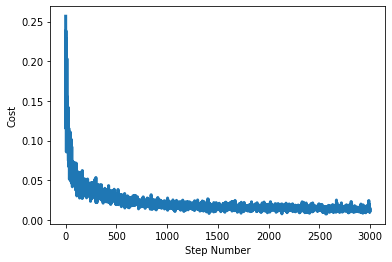

In [ ]:
#Now we can do the actual model training
steps = 3000
cost,y_target=generate_and_train(model2,circle_generator,img_size=27,batchsize=10,steps=steps)
#Plot the cost
fig, ax = plt.subplots()
stepArray=np.arange(steps) 
ax.plot(stepArray,cost,linewidth=3) 
ax.set_xlabel("Step Number") 
ax.set_ylabel("Cost")

From the plot, it can be seen that the cost starts at around 0.25 and decreases significantly after a few hundred steps. The task requires the cost to be lower than 0.02, and the graph shows that this is the case. This can be confirmed by outputting the cost array. In the code cell below, it can be seen that the final cost is 0.0140, with the last 3 steps having a cost of 0.0103, 0.0117, 0.0140 respectively, which is comfortably below the target cost of 0.02. 

An example input and output of the network can be seen below, which shows the output recreating the original input quite well. 

[0.25663728 0.15842383 0.23850119 ... 0.01029237 0.01165256 0.01402771]


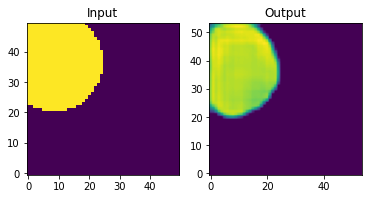

In [ ]:
print(cost)
plot_test_image(model2,circle_generator,50)

The code cell below shows the neurons per layer of the network `model2`. As required, the bottleneck layer has 9 neurons.

In [ ]:
print_layers(model2,y_target)

Layer 0: 2916 neurons /  (10, 27, 27, 4)
Layer 1: 324 neurons /  (10, 9, 9, 4)
Layer 2: 324 neurons /  (10, 9, 9, 4)
Layer 3: 36 neurons /  (10, 3, 3, 4)
Layer 4: 9 neurons /  (10, 3, 3, 1)
Layer 5: 81 neurons /  (10, 9, 9, 1)
Layer 6: 324 neurons /  (10, 9, 9, 4)
Layer 7: 2916 neurons /  (10, 27, 27, 4)
Layer 8: 2916 neurons /  (10, 27, 27, 4)
Layer 9: 2187 neurons /  (10, 27, 27, 3)


## Task 2

`model3` is an autoencoder that has a bottleneck layer of 3 neurons. This network is similar to `model2` but has an extra downsampling layer to get to the required 3 neurons and also another upsampling layer for better results. 

In [ ]:
model3=keras.models.Sequential()
# 3x3 kernel size, 10 channels in first hidden layer:
model3.add(keras.layers.Conv2D(4,5,input_shape=(None,None,1),activation="relu",padding='same'))
model3.add(keras.layers.AveragePooling2D(pool_size=(3,3),padding='same')) # down
model3.add(keras.layers.Conv2D(4,5,activation="relu",padding='same'))
model3.add(keras.layers.AveragePooling2D(pool_size=(3,3),padding='same')) # down
model3.add(keras.layers.Conv2D(3,3,activation="relu",padding='same'))
model3.add(keras.layers.AveragePooling2D(pool_size=(3,3),padding='same')) # down
model3.add(keras.layers.UpSampling2D(size=(3,3))) # up
model3.add(keras.layers.Conv2D(4,5,activation="relu",padding='same'))
model3.add(keras.layers.UpSampling2D(size=(3,3))) # up
model3.add(keras.layers.Conv2D(4,5,activation="relu",padding='same'))
model3.add(keras.layers.UpSampling2D(size=(3,3))) # up
model3.add(keras.layers.Conv2D(4,5,activation="relu",padding='same'))
model3.add(keras.layers.Conv2D(3,3,activation="relu",padding='same'))
model3.compile(loss='mean_squared_error',optimizer='adam')
model3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, None, None, 4)     104       
_________________________________________________________________
average_pooling2d_8 (Average (None, None, None, 4)     0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, None, None, 4)     404       
_________________________________________________________________
average_pooling2d_9 (Average (None, None, None, 4)     0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, None, None, 3)     111       
_________________________________________________________________
average_pooling2d_10 (Averag (None, None, None, 3)     0         
_________________________________________________________________
up_sampling2d_8 (UpSampling2 (None, None, None, 3)    

The code cell below trains `model3`, I chose 3000 steps and 10 batchsize after trial and error of differnt combinations. This satisfies the 30000 sample images limit and from testing, provides the lowest cost. From the plot, the loss function is similar to the network with a 9 neuron bottleneck. 

Text(0, 0.5, 'Cost')

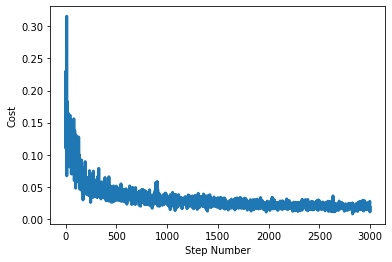

In [ ]:
#Now we can do the actual model training
steps = 3000
cost,y_target=generate_and_train(model3,circle_generator,img_size=27,batchsize=10,steps=steps)
#Plot the cost
fig, ax = plt.subplots()
stepArray=np.arange(steps) 
ax.plot(stepArray,cost,linewidth=3) 
ax.set_xlabel("Step Number") 
ax.set_ylabel("Cost")

By outputting the cost array, it can be seen that the last 3 steps of the training has a cost of 0.0122, 0.108, 0.0177, which satisfies even the cost requirement for the network with a 9 neuron bottleneck. This is surprising as I expected this network to have a higher cost as this network has downsamples the input image significantly to a (10, 1, 1, 3) shape. However, the output still maintains a cost similar to the 9 neuron bottleneck network which downsamples the input to (10, 3, 3, 1).

Prior to training the network, I had a cost limit of 0.03 - 0.05 in mind; however, since this model exceeds the cost limit significantly, I would say a good target for this network with a 3 neuron bottleneck is 0.02. 

In [ ]:
print(cost)
print_layers(model3,y_target)

[0.17020062 0.11019002 0.23044233 ... 0.01221573 0.01080084 0.01774201]
Layer 0: 2916 neurons /  (10, 27, 27, 4)
Layer 1: 324 neurons /  (10, 9, 9, 4)
Layer 2: 324 neurons /  (10, 9, 9, 4)
Layer 3: 36 neurons /  (10, 3, 3, 4)
Layer 4: 27 neurons /  (10, 3, 3, 3)
Layer 5: 3 neurons /  (10, 1, 1, 3)
Layer 6: 27 neurons /  (10, 3, 3, 3)
Layer 7: 36 neurons /  (10, 3, 3, 4)
Layer 8: 324 neurons /  (10, 9, 9, 4)
Layer 9: 324 neurons /  (10, 9, 9, 4)
Layer 10: 2916 neurons /  (10, 27, 27, 4)
Layer 11: 2916 neurons /  (10, 27, 27, 4)
Layer 12: 2187 neurons /  (10, 27, 27, 3)


The test image below shows the input image using the circle_generator function and the output using `model3`. The recreated image represents the original quite well considering the bottleneck, but the position and shape of the circle are not very accurate and the model also outputs something below the circle. 

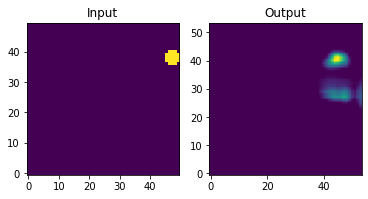

In [ ]:
plot_test_image(model3,circle_generator,50)